In [1]:
import pandas as pd
import camelot

## Parse table from PDF

In [2]:
filename = 'data/Apple-Supplier-List.pdf'
tables = camelot.read_pdf(filename, flavor='stream', pages='1-end')

In [3]:
companies = pd.concat(
    [tables[0].df[5:-1]] +
    [table.df[:-1] for table in tables[1:-1]] +
    [tables[-1].df[4:12]]
).drop(columns=[2]) \
.rename(columns={0: 'supplier_name', 1: 'address'}) \
.reset_index(drop=True)

In [4]:
companies[10:15]

,supplier_name,address
10,AAC Technologies Holdings Inc.,"No. 8 Fengqi Road, High Tech. Industry Develop..."
11,,"District, Changzhou, Jiangsu, China"
12,AAC Technologies Holdings Inc.,"No. 66 Yanghuxi Road, Wujin District, Changzho..."
13,"Advanced International Multitech Co., Ltd.","Building F, Pengjinghui Industrial Park, No. 5..."
14,,"Village, Humen Town, Dongguan, Guangdong, China"


In [5]:
def fix_multirow(companies, mr_col, merge_col, multiline_vals=[None, '']):
    to_drop = []

    for i, row in companies.iterrows():
        if row[mr_col].strip() in multiline_vals:
            prev_row = companies.iloc[i-1]

            prev_row[merge_col] += ' ' + row[merge_col]
            if len(row[mr_col].strip()) > 0:
                prev_row[mr_col] += ' ' + row[mr_col]
            
            to_drop.append(i)

    return companies.drop(to_drop).reset_index(drop=True)

In [6]:
c1 = fix_multirow(companies, 'supplier_name', 'address')
c2 = fix_multirow(c1, 'address', 'supplier_name')

In [7]:
multiline_corps = [
    '(Foxconn)',
    '(Foxlink)',
    '& Systemtechnik AG',
    'Co., Ltd.',
    'Co., Ltd. (TSMC)',
    'Manufacturing Co., Ltd.',
    'Products Co., Ltd.',
    'Technology Co., Ltd.',
]

final = fix_multirow(c2, 'supplier_name', 'address', multiline_corps)

## Geolocate all the addresses

Geolocating through Google API is not free (and it's slow), so adding a caching layer.

In [5]:
import configparser
config = configparser.ConfigParser()
config.read('secrets.ini')

MAPS_API_KEY = config['GoogleMaps']['ApiKey']

In [6]:
import sys
sys.path.append(".")

from apple_suppliers.geolocation import Geolocation

gl = Geolocation(MAPS_API_KEY)
gl.extract_region('1600 Amphitheatre Parkway, Mountain View, CA')

'California'

In [10]:
from apple_suppliers.log_progress import log_progress

for addr in log_progress(final.address):
    gl.geocode(addr)

In [11]:
# Manually fix address that didn't geocode correctly

gl.cache['560 Moo 2 Bangpa-in Industrial Estate, Udomsorayuth Road, T.Klong-Jik, Bang Pa-In, Ayutthaya, Thailand'] = \
    gl.geocode('Udomsorayuth Road, T.Klong-Jik, Bang Pa-In, Ayutthaya, Thailand')

gl.cache['No. 18 Pan Long Shan Road, Jiangyin, Jiangsu, China'] = \
    gl.geocode('Pan Long Shan, Jiangyin, Jiangsu, China')

gl.cache['No. 2275 Chengliu Zhonglu, Jiading District, Shanghai, China'] = \
    gl.geocode('Prent Corp. No. 2275 Chengliu Zhonglu, Jiading District, Shanghai, China')

gl.cache['727 Kihara, Kiyotake-cho, Miyazaki, Japan'] = \
    gl.geocode('Kihara, Kiyotake-cho, Miyazaki, Japan')

gl.write_cache()

In [12]:
final['lat'] = final.address.apply(gl.extract_lat)
final['lng'] = final.address.apply(gl.extract_lng)
final['country'] = final.address.apply(gl.extract_country)
final['region'] = final.address.apply(gl.extract_region)

final.to_csv('data/suppliers.csv')

In [21]:
final = pd.read_csv('data/suppliers.csv', index_col=0)

## Distribution by country

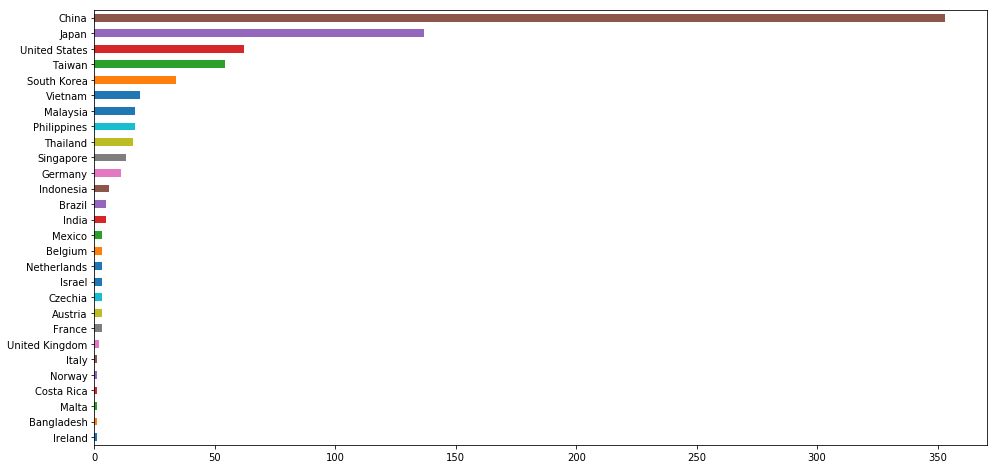

In [3]:
final.country.value_counts(ascending=True).plot(kind='barh', figsize=(16,8))

## The Map

In [7]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key=MAPS_API_KEY)

fig = gmaps.figure(center=(0, 0), zoom_level=2, display_toolbar=False, 
                   layout={'width': '950px', 'height': '750px'})

info_box_template = """
<dl>
<dt>{name}</dt>
<dd>{address}</dd>
</dl>
"""
info = [info_box_template.format(name=row.supplier_name, address=row.address) for i, row in final.iterrows()]

symbols = gmaps.symbol_layer(final[['lat', 'lng']], info_box_content=info,
                             fill_color='blue', fill_opacity=.6, stroke_color='blue', stroke_opacity=0, scale=2)
fig.add_layer(symbols)

heatmap = gmaps.heatmap_layer(final[['lat', 'lng']], dissipating=False, point_radius=3)
fig.add_layer(heatmap)

fig

Figure(layout=FigureLayout(height='750px', width='950px'))

In [32]:
from ipywidgets import HTML
from ipyleaflet import Map, MarkerCluster, CircleMarker

m = Map(center=(30, 0), zoom=2)

markers = []
for i, row in final.iterrows():
    cm = CircleMarker(location=(row.lat, row.lng), radius=5)
    cm.popup = HTML("<b>{name}</b><br>{address}".format(name=row.supplier_name, address=row.address))
    markers.append(cm)

m.add_layer(MarkerCluster(markers=markers))

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …